# Universidad del Valle de Guatemala
## Security Data Science - 10
* Jose Abraham Gutierrez Corado - 19111
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 1: Detección de Pishing

## PARTE 1

### Importación de Librearias

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
%matplotlib inline
#from yellowbrick.features import Rank2D
#from yellowbrick.features import RadViz

### Explorar Datos

In [2]:
df = pd.read_csv('dataset_pishing.csv')
df.head(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
df[df.status == 'legitimate'].sample(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
8487,http://www.homeandlearn.co.uk/NET/nets4p10.html,0,1,0,0,0,0,0,0,0,...,1,0,0,240,6700,36431,0,1,5,legitimate
9457,https://helpathome.jobs.net/,0,0,0,0,0,0,0,0,0,...,1,0,0,199,8934,18070,0,0,5,legitimate
367,http://www.skm-eleksys.com/2011/02/transmissio...,0,1,0,0,0,0,0,0,0,...,1,0,0,120,3167,3345571,0,0,2,legitimate
8458,http://www.celloshop.com/,0,1,0,0,0,0,0,0,0,...,0,1,0,112,7559,1777191,0,0,2,legitimate
1111,https://techterms.com/definition/database,0,0,0,0,0,0,0,0,0,...,1,1,0,1944,7187,20789,0,0,5,legitimate


In [4]:
df[df.status == 'phishing'].sample(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
8694,https://kongrespdgi.com/asset/ajax/onlin/Wells...,1,0,0,0,0,0,0,0,0,...,1,0,0,125,241,0,0,1,0,phishing
7588,https://www.scifiline.com/wp-admin/maint/scripts,0,1,0,0,0,0,0,0,0,...,1,0,0,208,157,5376297,0,1,1,phishing
9725,http://107.180.44.78/login.php?cmd=login_submi...,1,0,0,0,0,0,0,1,1,...,1,1,1,0,-1,0,1,0,0,phishing
4234,https://bankmaluku.co.id/chase/chase/home,0,0,0,0,0,0,0,0,0,...,1,0,0,194,4562,8152853,0,1,2,phishing
6724,https://outlook-webapp-portal.el.r.appspot.com...,0,0,0,0,0,0,0,0,0,...,1,1,0,228,5616,0,0,1,5,phishing


Si se encuentra balanceado.

In [5]:
df.shape

(11430, 67)

### Derivación de Características
Las características del articulo son:
* f1: Full URL length
* f2: Hostname length
* f4-f20: Special Characters in URL
* f25: HTTPS Token
* f26: Ratio of digits in full URLs
* f27: Ratio of digits in hostnames

In [153]:
# Creamos un nuevo dataframe para que sea más fácil la manipulación de datos
df_copy = df.copy()

### Listado de Partes de una URL
* Protocolo HTTPS
* Subdominio
* Dominio
* TLD
* Ruta
* Parámetro
* Etiqueta

### Funciones

In [158]:
# Obtenemos F1
df_copy['length'] = df_copy['url'].str.len()

In [8]:
#Obtenemos F2
from urllib.parse import urlparse

def getHostname(dfNew):
    hostnames = []
    for url in dfNew.url:
        hostnames.append('{uri.scheme}://{uri.netloc}/'.format(uri=urlparse(url)))
    
    dfNew['hostname_length'] = hostnames
    
    dfNew['hostname_length'] = dfNew['hostname_length'].str.len()
    
    return dfNew

#Obtenemos la columna de las carateristicas F4 - F20
def SpecialCharacters(dfNew):
    sChars = [".","-", "@", "?", "&", "|", "=", "_", "~", "%", "/", "*", ":", ",", ";", "$", "%20", " "]
    cont = 0
    scCount = []
    for url in dfNew.url:
        for c in url:
            if (c in sChars) and (c != "%"):
                cont += 1
                
            elif c == "%":
                c2 = url.index(c)
                c2 = c + url[c2]
                
                if c2 == "%2":
                    cont += 1
                else:
                    cont += 1
                    
        scCount.append(cont)
        cont = 0
        
    dfNew['Special_Char_Count'] = scCount
    
    return dfNew

#Obtenemos si la URL tiene HTTPS o no
def Check4HTTPS(dfNew):
    check = []
    for url in dfNew.url:
        if "https" in url:
            check.append(1)
        else:
            check.append(0)
    
    dfNew['HTTPS'] = check
    return dfNew

#Obtenemos el ratio de números en la URL y en el Hostname
def ratioDigits(dfNew):
    digits = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    hostnames = []
    urlDigits = []
    hostnameDigits = []
    cont1 = 0
    cont2 = 0
    
    for url in dfNew.url:
        for c in url:
            if c in digits:
                cont1 += 1
                
        urlDigits.append(cont1/len(url))
        cont1 = 0
        hostnames.append('{uri.scheme}://{uri.netloc}/'.format(uri=urlparse(url)))
    
    for hn in hostnames:
        for c in hn:
            if c in digits:
                cont2 += 1
                
        hostnameDigits.append(cont2/len(hn))
        cont2 = 0
        
    dfNew['urlDigits_ratio'] = urlDigits
    dfNew['hostnameDigits_ratio'] = hostnameDigits
    
    return dfNew

### Ejecutar las funciones en el dataset

In [161]:
df_copy = getHostname(df_copy)
df_copy = SpecialCharacters(df_copy)
df_copy = Check4HTTPS(df_copy)
df_copy = ratioDigits(df_copy)

Dataframe resultante con las nuevas columnas

In [187]:
df_copy.sample(5)

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,dns_record,google_index,page_rank,status,length,hostname_length,Special_Char_Count,HTTPS,urlDigits_ratio,hostnameDigits_ratio
10831,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,73,16,13,0,0.000000,0.000000
695,0,0,1,0,0,0,0,1,0,0,...,0,1,3,1,70,39,13,0,0.028571,0.051282
8256,0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,69,23,15,1,0.246377,0.000000
11014,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,42,42,7,1,0.000000,0.000000
11279,0,0,0,0,0,0,0,0,0,0,...,0,1,5,1,70,50,11,1,0.042857,0.060000


### Preprocesamiento
Eliminación de columna Dominio y status de categorica a binaria

In [163]:
df_copy['status'] = df['status'].replace(['legitimate', 'phishing'], ['0', '1'])
df_copy.drop(['url'], axis=1, inplace=True)

### Visualización de Resultados

In [165]:
profile = ProfileReport(df_copy, title="Detecting Pishing in URLs")
profile.to_file("Pishing.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Selección de Características

Se consideraron aquellas variables que tuvieran una indice de correlacion mayor a 0.20 respecto a la variable <b>"status"</b> dado a que esta será la variable dependiente (target). Esto puede ser verificado con el mapa de calor obtenido en la sección anterior.

In [173]:
df_copy2 = df_copy[['shortest_word_host', 'phish_hints', 'ratio_intHyperlinks',
                    'ratio_extHyperlinks', 'ratio_extRedirection', 'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 
                    'ratio_extMedia', 'safe_anchor', 'page_rank', 'hostname_length', 'urlDigits_ratio', 
                    'hostnameDigits_ratio', 'ip', 'nb_www', 'tld_in_subdomain', 'nb_subdomains', 'prefix_suffix', 
                    'empty_title', 'domain_in_title', 'google_index', 'Special_Char_Count', 'status']]

Eliminación de datos duplicados

In [171]:
df_copy2.drop_duplicates()

,shortest_word_host,phish_hints,ratio_intHyperlinks,ratio_extHyperlinks,ratio_extRedirection,ratio_extErrors,links_in_tags,ratio_intMedia,ratio_extMedia,safe_anchor,...,hostnameDigits_ratio,ip,nb_www,tld_in_subdomain,nb_subdomains,prefix_suffix,empty_title,domain_in_title,google_index,Special_Char_Count
0,3,0,0.529412,0.470588,0.875000,0.500000,80.000000,100.000000,0.000000,0.000000,...,0.0,0,1,0,3,0,0,0,1,7
1,19,0,0.966667,0.033333,0.000000,0.000000,100.000000,80.000000,20.000000,100.000000,...,0.0,1,0,0,1,0,0,1,1,7
2,3,0,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,...,0.0,1,0,1,3,1,0,1,1,19
3,5,0,0.973154,0.026846,0.250000,0.250000,100.000000,96.428571,3.571429,62.500000,...,0.0,0,0,0,2,0,0,1,0,5
4,3,0,0.470588,0.529412,0.537037,0.018519,76.470588,0.000000,100.000000,0.000000,...,0.0,0,1,0,2,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,3,0,0.884422,0.115578,0.043478,0.173913,80.000000,21.052632,78.947368,0.000000,...,0.0,0,1,0,2,0,0,0,0,7
11426,3,0,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,...,0.0,0,1,0,3,0,0,1,1,15
11427,3,0,0.470588,0.529412,0.000000,0.000000,6.250000,0.000000,0.000000,80.000000,...,0.0,1,1,0,2,0,0,0,1,17
11428,3,0,0.375000,0.625000,0.050000,0.050000,16.666667,0.000000,100.000000,0.000000,...,0.0,0,1,0,2,0,0,1,0,6


## PARTE 2

### Separacion de datos

Para este análisis, la varible dependiente o respuesta será <b>"status"</b> dado a que este es el que indica si un link es DGA o no. Y por lo tanto, el resto de variables serán las independientes.

In [174]:
#Datos de entrenamiento: 55% 
#Datos de validación: 15% 
#Datos de prueba: 30%

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy2, target='status', 
                                                                            train_size=0.55, valid_size=0.15, test_size=0.3)

Se almacenan los datos como CSV.

In [188]:
X_test.to_csv('test_dataset.csv', index = False, encoding='utf-8')
X_valid.to_csv('validation_dataset.csv', index = False, encoding='utf-8')
X_train.to_csv('train_dataset.csv', index = False, encoding='utf-8')

### Modelos 

<h3 style="color:#FF0000">Random Forest Classifier Model</h3>

<h4 style="color:#FF0000">Creación</h4>

In [189]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

<h4 style="color:#FF0000">Puntaje del modelo</h4>

In [186]:
# Predictions
predictions = rf.predict(X_valid)

# Get the results y_valid
print('Model Score: ',metrics.accuracy_score(y_valid, predictions))

Model Score:  0.9579929988331388


<h4 style="color:#FF0000">Matriz de confusión</h4>

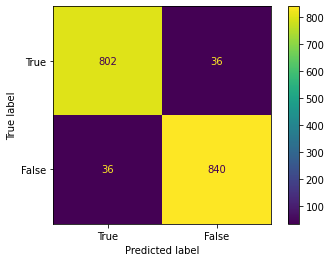

In [199]:
confusion_matrix = metrics.confusion_matrix(y_valid, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])
cm_display.plot()
plt.show() 

<h4 style="color:#FF0000">Reporte de metricas</h4>

In [184]:
print(metrics.classification_report(y_valid, predictions, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.96      0.96      0.96       838
         dga       0.96      0.96      0.96       876

    accuracy                           0.96      1714
   macro avg       0.96      0.96      0.96      1714
weighted avg       0.96      0.96      0.96      1714



<h3 style="color:#d19b04">Decision Forest Classifier Model</h3>

<h4 style="color:#d19b04">Creación</h4>

In [177]:
clf = tree.DecisionTreeClassifier()  
clf = clf.fit(X_train, y_train)

<h4 style="color:#d19b04">Puntaje del modelo</h4>

In [192]:
# Predictions
predictions2 = clf.predict(X_valid)

print('Model Score: ', metrics.accuracy_score(y_valid, predictions2))

Model Score:  0.9311551925320887


<h4 style="color:#d19b04">Matriz de confusión</h4>

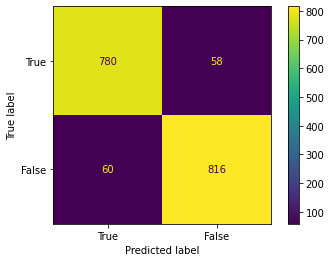

In [200]:
confusion_matrix = metrics.confusion_matrix(y_valid, predictions2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])
cm_display.plot()
plt.show() 

<h4 style="color:#d19b04">Reporte de métricas</h4>

In [193]:
print(metrics.classification_report(y_valid, predictions2, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.93      0.93      0.93       838
         dga       0.93      0.93      0.93       876

    accuracy                           0.93      1714
   macro avg       0.93      0.93      0.93      1714
weighted avg       0.93      0.93      0.93      1714



<h3 style="color:#069605">Extra Tress Classifier Model</h3>

<h4 style="color:#069605">Creación</h4>

In [194]:
eclf = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
eclf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

<h4 style="color:#069605">Puntaje del modelo</h4>

In [196]:
# Predictions
predictions3 = eclf.predict(X_valid)

print('Model Score: ', metrics.accuracy_score(y_valid, predictions3))

Model Score:  0.9498249708284714


<h4 style="color:#069605">Matriz de confusión</h4>

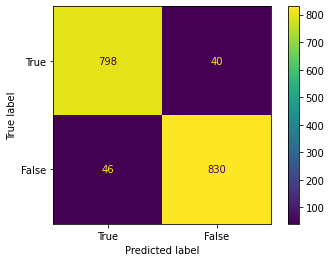

In [201]:
confusion_matrix = metrics.confusion_matrix(y_valid, predictions3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])
cm_display.plot()
plt.show() 

<h4 style="color:#069605">Reporte de métricas</h4>

In [198]:
print(metrics.classification_report(y_valid, predictions3, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.95      0.95      0.95       838
         dga       0.95      0.95      0.95       876

    accuracy                           0.95      1714
   macro avg       0.95      0.95      0.95      1714
weighted avg       0.95      0.95      0.95      1714



Como se puede ver en las metricas, podemos observar que el modelo durante la detección de los DGA tiene una precisión del 95% lo que indica que puede predecir y clasificar hasta el 95% correcto, ademas de esto podemos ver que con respecto a esto, tiene una clasificación(recall) del 95%, por lo que de los DGA que clasifico, solo en 5% fallo. No es necesario agregar más controles, debido a que existe una proporción tan baja para tomar en cuenta el error o similar.

# Discusión

<ol>
<li>¿Cuál es el impacto de clasificar un sitio legítimo como Pishing?</li>
<li>¿Cuál es el impacto de clasificar un sitio de Pishing como legítimo?</li>
<li>En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de pishing? </li>
<li>¿Qué modelo es mejor para la clasificación de Pishing? Justifique</li>
<li>En base a las métricas obtenidas ¿es necesaria la intervención de una persona humana para tomar la decisión final?</li>
</ol>

<ol>
    <li>El impacto de clasificar si un sitio que parece ser legítimo es en realidad Phishing es que este tipo de algoritmos puedan ser usados en otras herramientas para advertirle al usuario de que el URL presente no es seguro. Como la implementación de Machine Learning dentro de los correos electronicos para evitar que los consumidores presionen las URLs y se les sean robados sus datos confidenciales, como lo puede ser sus credenciales de acceso o numeros de tarjetas de creditos dado a que una gran mayoria de los robos de informacion sensible es por medio de phishing.</li>
    <li>El impacto que puede tener en clasificar un sitio de phishing como legítimo es que los usuarios tendrán la confianza suficiente para ingresar sus credenciales sin problemas dado a que no estarían sospechando de nada y más cuando el mismo navegador verificó que si es veridico.</li>
    <li>La metríca que usaría para saber cual modelo es mejor que el resto para la detección de phishing sería <b>recall</b> dado a que quiero evitar los falsos positivos y reconocer un link de Phishing como legítimo por la razón mencionada anteriormente. Con esto estoy obteniendo la información mas relevante.</li>
    <li>El mejor modelo en este experimento es <b>Random Forest Classifier</b> dado a que obtuvo el mejor puntaje en accuracy y a su vez el mejor valor en recall (0.96 > 0.95 > 0.93).</li>
    <li>En base a las métricas obtenidas creemos que no es necesario la intervención humana dado a que con el mejor modelo, el 4% de las preddciones no serían correctas pero este es un porcentaje muy pequeño y los casos dentro de este serían muy excepcionales porque estaríamos hablando de URLs de Phishing con características demasiado específicas de un URL verídico. En otras palabras, se tendrían varías variables con valores similares y esto es muy dificil de lograr.</li>
</ol>